In [1]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.preprocessing
import pandas as pd, numpy as np
from datetime import datetime, date
from matplotlib import pyplot as plt
import seaborn as sns

# Demand Elasticity Example: Data Preprocessing

We will generate a subset of a real data set from a UK retail firm, which has been used in a more extensive [blog post on demand elasticity estimation by Lars Roemheld (Roemheld, 2021)](https://towardsdatascience.com/causal-inference-example-elasticity-de4a3e2e621b). The accompanying code and the data set that has been used in the blog post are available from a [GitHub repository](https://github.com/larsroemheld/causalinf_ex_elasticity). The original data set is a public domain (CC0 1.0 Universal) data set, made available via [kaggle](https://www.kaggle.com/vijayuv/onlineretail).

The estimation of price elasticities has also been explored by [Erik Kaunismäki (2021)](https://helda.helsinki.fi/dhanken/bitstream/handle/10227/441224/Kaunism%C3%A4ki_Erik.pdf?sequence=1) and [Kuan-Pin Lin (2019)](http://web.pdx.edu/~crkl/BDE/MLE-4.pdf). We follow [Roemheld (2021)](https://towardsdatascience.com/causal-inference-example-elasticity-de4a3e2e621b) and acknowledge a technical limitation of the data set in that we only observe sales, not stock days. That means that we have no data at on prices on days where no sales (sales = 0) occurred. It is an issue since typically most of the units are rarely sold; However, we pass over it for the example.

To process the data set we proceed as follows: We depart from a cleansed data set used in the analysis of [Roemheld (2021)](https://towardsdatascience.com/causal-inference-example-elasticity-de4a3e2e621b). We will first reproduce the preprocessing steps in his [notebook](https://github.com/larsroemheld/causalinf_ex_elasticity/blob/main/elasticity_dml.ipynb) and later mimick the feature engineering. Finally, we select a subset of the entire data set to have a computationally tractable example.

In the first step, [Roemheld (2021)](https://towardsdatascience.com/causal-inference-example-elasticity-de4a3e2e621b) processes the raw data set with information on sales, product codes, quantities and unit prices, country, and description of the product. During preprocessing, outliers were dropped, for example if they have unbelievable high quantities and unit prices. 
The preprocessed data. The preprocessed data has information on the date (`Date`), the stock keeping unit (`StockCode`, identifying a product), country (`Country`), a short product description as text (`Description`), quantity sold (`Quantity`), revenue (`revenue`) and the price per unit of a product (`UnitPrice`). 


## Data Preprocessing in  [Roemheld (2021)](https://towardsdatascience.com/causal-inference-example-elasticity-de4a3e2e621b)

We have already preprocesed data from 
It seems that start date sales vary between countries. The sales have been recorded since December 2010.

In [2]:
# To load data install pyarrow in case you haven't installed it before
!pip install pyarrow

# Load preprocessed data set used in Roemheld (2021) from URL
# Note: An internet connection is required
df = pd.read_parquet('https://github.com/larsroemheld/causalinf_ex_elasticity/blob/main/ecom_sample_clean.parquet?raw=true')

In [3]:
# Number of rows and columns
df.shape

(298222, 7)

In [4]:
# Columns in the data set
df.columns

Index(['Date', 'StockCode', 'Country', 'Description', 'Quantity', 'revenue',
       'UnitPrice'],
      dtype='object')

In [5]:
# Glimpse at head of the data
df.head()

,Date,StockCode,Country,Description,Quantity,revenue,UnitPrice
0,2010-12-01,10002,France,INFLATABLE POLITICAL GLOBE,48,40.80,0.85
1,2010-12-01,10002,United Kingdom,INFLATABLE POLITICAL GLOBE,12,10.20,0.85
2,2010-12-01,10125,United Kingdom,MINI FUNKY DESIGN TAPES,2,1.70,0.85
3,2010-12-01,10133,United Kingdom,COLOURING PENCILS BROWN TUBE,5,4.25,0.85
4,2010-12-01,10135,United Kingdom,COLOURING PENCILS BROWN TUBE,1,2.51,2.51


In [6]:
df_example = df.iloc[0:10]
# Save example data set for illustration purpose in analysis notebook
df_example.to_csv("data/orig_demand_data_example.csv")

### Variance of prices per product


There are 3914 products in this data set. We need variation in unit prices within products to estimate elasticity. We choose to make a histogram of the standard variation of the products to identify the distribution of standard deviation between products. We see that there are price products that do not vary over time.

In [7]:
# Number of unique products
print(len(pd.unique(df['StockCode'])))

3914


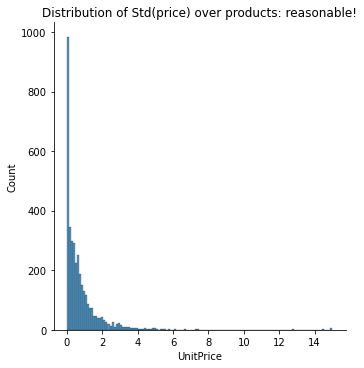

In [8]:
sns.displot(df.groupby('StockCode').UnitPrice.std().dropna().clip(0, 15), kde=False)
plt.title('Distribution of Std(price) over products: reasonable!');

We drop those products which their prices do not vary over time.

In [9]:
df_mdl = df[
    (df.groupby('StockCode').UnitPrice.transform('std') > 0)
]

In [10]:
len(df_mdl)

294575

##  Mimick Feature Engineering in  [Roemheld (2021)](https://towardsdatascience.com/causal-inference-example-elasticity-de4a3e2e621b)

To estimate the price elasticity of demand we have to log-transform the variable on the price and quantity.

In [11]:
# Generate Logs of main variables
df_mdl = df_mdl.assign(
    LnP = np.log(df_mdl['UnitPrice']),
    LnQ = np.log(df_mdl['Quantity']),
)

We transform the `Date` variable in a way that we have separate variables on the month, the day of the month, the day of the week as well as the stock age, how and the average (median) price of a product.

In [12]:
# Get information from dates and stock code
df_mdl = df_mdl.assign(
    # Month
    month = lambda d: d.Date.dt.month,
    # Day of Month
    DoM =   lambda d: d.Date.dt.day,
    # Day of Week
    DoW =   lambda d: d.Date.dt.weekday,
    # Stock age: Number of days the product has been sold
    stock_age_days = lambda d: 
        (d.Date - d.groupby('StockCode').Date.transform('min')).dt.days,
    # Stock average price: Median of the price
    sku_avg_p = lambda d: 
        d.groupby('StockCode').UnitPrice.transform('median')
)

To replicate the feature generation in the pipeline defined in the original [notebook](https://github.com/larsroemheld/causalinf_ex_elasticity/blob/main/elasticity_dml.ipynb), we apply the same transformations on the entire data set and later pass this as a backend to DoubleML.

In [13]:
# Get one hot encoding of Date column
one_hot = pd.get_dummies(df_mdl.Date)
# Drop column B as it is now encoded
df_mdl2 = df_mdl.drop('Date',axis = 1).copy()
# Join the encoded df_mdl
df_mdl2 = df_mdl2.join(one_hot)

In [14]:
print(df_mdl2.shape)

(294575, 318)


In [15]:
# Get one hot encoding of Country column
one_hot = pd.get_dummies(df_mdl.Country)
# Drop column B as it is now encoded
df_mdl3 = df_mdl2.drop('Country',axis = 1).copy()
# Join the encoded df_mdl
df_mdl3 = df_mdl3.join(one_hot).reset_index(drop = True)

In [16]:
print(df_mdl3.shape)

(294575, 355)


In [17]:
# Get information from description data
# We get tokens and generate columns using words
tokens = CountVectorizer(min_df=0.0025, ngram_range=(1, 3)).fit_transform(df_mdl3['Description'])
df_mdl4 = df_mdl3.join(pd.DataFrame(tokens.toarray()))

In [18]:
print(df_mdl4.shape)

(294575, 907)


We could one-hot encode the `StockCode` variable too, but it implies to have too much variables and will therefore overfit the ML models. We decide to drop Stock Code fixed effects by de-meaning variables. 

$$
\text{dLnP}_{i,t} = \log(p_{i,t}) - \log(\bar{p_i})
$$

$$
\text{dLnQ}_{i,t} = \log(Q_{i,t}) - \log(\bar{Q_i})
$$

In [19]:
# Note that de-meaning happens on StockCode-level here!
df_mdl4['dLnP'] = np.log(df_mdl4.UnitPrice) - np.log(df_mdl4.groupby('StockCode').UnitPrice.transform('mean'))
df_mdl4['dLnQ'] = np.log(df_mdl4.Quantity) - np.log(df_mdl4.groupby('StockCode').Quantity.transform('mean')) 

In [20]:
# Drop Variables that are not necessary
df_mdl5 = df_mdl4.drop( ['LnP', 'LnQ', 'StockCode', 'Description' ], axis = 1 ).copy()

In [21]:
df_mdl5.head()

,Quantity,revenue,UnitPrice,month,DoM,DoW,stock_age_days,sku_avg_p,2010-12-01 00:00:00,2010-12-02 00:00:00,...,544,545,546,547,548,549,550,551,dLnP,dLnQ
0,48,40.80,0.85,12,1,2,0,0.850000,1,0,...,0,0,0,0,0,0,0,0,-0.173158,1.046094
1,12,10.20,0.85,12,1,2,0,0.850000,1,0,...,0,0,0,0,0,0,0,0,-0.173158,-0.340200
2,2,1.70,0.85,12,1,2,0,0.850000,1,0,...,0,0,0,0,0,0,0,0,-0.015594,-2.211211
3,5,4.25,0.85,12,1,2,0,0.659667,1,0,...,0,0,0,0,0,0,0,0,0.257981,-1.615385
4,1,2.51,2.51,12,1,2,0,1.250000,1,0,...,0,0,0,0,0,0,0,0,0.551839,-2.918686


In [22]:
print(df_mdl5.shape)

(294575, 905)


## Select and Save a Subset of the Data

To have an example that's easier to replicate, we select and save a subset of the data set only.

In [23]:
df_mdl_final = df_mdl5.sample(n = 10000, random_state = 42)

In [24]:
df_mdl_final.shape

(10000, 905)

In [25]:
df_mdl_final.to_csv('data/elasticity_subset.csv')

## Comparison to OLS DML Results in [Roemheld (2021)](https://towardsdatascience.com/causal-inference-example-elasticity-de4a3e2e621b) (with full data set)

The following code replicates the analysis (DML with linear regression learner) in [Roemheld (2021)](https://towardsdatascience.com/causal-inference-example-elasticity-de4a3e2e621b) using the full data set.

Note: As in the [notebook](https://github.com/larsroemheld/causalinf_ex_elasticity/blob/main/elasticity_dml.ipynb), no random seed is set, numerical differences might occur.

In [26]:
feature_names = list(df_mdl5.columns[4:(df_mdl5.shape[1]-2),])

In [27]:
import doubleml as dml
data_dml_base = dml.DoubleMLData(df_mdl5,
                                 y_col = "dLnQ",
                                 d_cols = "dLnP",
                                 x_cols = feature_names)

In [28]:
from sklearn.linear_model import LinearRegression

ols1a = LinearRegression(n_jobs = -1)

dml_plr_ols1a = dml.DoubleMLPLR(data_dml_base,
                                ml_g = ols1a,
                                ml_m = ols1a,
                                n_folds = 2,
                              score = 'partialling out')

dml_plr_ols1a.fit(store_predictions=True)
dml_plr_ols1a.summary

ols1a_summary = dml_plr_ols1a.summary

In [29]:
ols1a_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
dLnP,-1.898493,0.008045,-235.969665,0.0,-1.914262,-1.882724


In [30]:
from sklearn.linear_model import LinearRegression

ols1b = LinearRegression(n_jobs = -1)

dml_plr_ols1b = dml.DoubleMLPLR(data_dml_base,
                                ml_g = ols1b,
                                ml_m = ols1b,
                                n_folds = 2,
                              score = 'IV-type')

dml_plr_ols1b.fit(store_predictions=True)
dml_plr_ols1b.summary

ols1b_summary = dml_plr_ols1b.summary

In [31]:
ols1b_summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
dLnP,-1.909038,0.008208,-232.594377,0.0,-1.925124,-1.892951
